## New York City's standardized tests for high schools

For the purposes of this project, we'll be using data about New York City public schools from https://data.cityofnewyork.us/browse?category=Education

 We will try to find out if standardized tests are unfair to certain groups of students. We will investigate if there are any correlations between SAT (Scholastic Aptitude Test) scores and demographics and then with factors like race, gender and more.
  For these purposes we will download several different dataframes from above mentioned webpage and combine them.
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# !conda install -c conda-forge geopy --yes
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import os
import json
# !conda install -c conda-forge folium --yes
import folium
import scipy.stats

%matplotlib inline


__We have several csv and txt files which we will use and here are some basic informations about them:__

    sat_results.csv - SAT scores for each high school in New York City (only for high school students)
    hs_directory.csv - A directory of high schools in New York City
    class_size.csv - Information on class size for each school
    ap_2010.csv - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
    graduation.csv - The percentage of students who graduated, and other outcome information
    demographics.csv - Demographic information for each school
    survey_all.txt / survey_d75.txt - Surveys of parents, teachers, and students at each school and from New York City district 75

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations.

In [2]:
# We will save all the csv files into folder "schools" and these are their names
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

In [3]:
# We will save all the dataframes into one dictionary each under its name as a key
data = {}
for df in data_files:
    data[df[:-4]] = pd.read_csv(df)

In [4]:
# First look
print(pd.DataFrame.head(data['sat_results']))

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

__We can see that we might eventually want to combine the three columns that contain SAT scores into a single column to make the scores easier to analyze.__


Other usefull information for our project:
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN, or district borough number.
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

In [5]:
# We will check all the other DFs as well

In [6]:
for k in data.keys():
    print()
    print(k)
    print()
    print(pd.DataFrame.head(data[k]))


ap_2010

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  

class_size

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K

__Each data set appears to have a DBN column, but some of them have duplicate DBN values, because they contain multiple rows with informations for each school.__

In [7]:
# But still we have two other files, which we have to connect to others, but these two are in txt file
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__There are more than 2000 columns and most of them we don't need. These data have a dbn column  as well but we just have to change it to uppercase.__

__From this location ( https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8 ) we can get a data dictionary, which contains the meanin of each column and its abbreviation.__

In [8]:
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

In [9]:
# CHanging to uppercase
survey.rename(columns={'dbn':'DBN'}, inplace=True)

# Based on the dictionary we will pick these columns:
survey = survey[survey_fields].copy()

In [10]:
# Saving the variable to our dictionary
data['survey'] = survey


In [11]:
# hs_directory does have again dbn column in lowercase
data["hs_directory"].rename(columns= {"dbn":"DBN"}, inplace = True)


In [12]:
# class_size doesn't have DBN column, but DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size
# whenever the CSD is less than two digits long, we need to add a 0 ahead

def amount(x):
    xx = str(x)
    if len(xx) == 1:
        return "0" + xx
    else:
        return xx
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(amount) #Creating a new column in class_size

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [13]:
# Now we create column with the sum of all SAT scores which will make it easier to correlate them with demographic factors
# First we have to change the values in those three columns into numbers and the missing values into null

sat = ["SAT Math Avg. Score", "SAT Critical Reading Avg. Score", "SAT Writing Avg. Score"]
for s in sat:
    data["sat_results"][s] = pd.to_numeric(data["sat_results"][s], errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]


In [14]:
# We want to work with locations so we can show the results on a map, we can use information from hs_directory and its column Location 1
# We just want the latitude and longtitude, the rest we will leave

def latitude(x): # Creating a function that will extract latitude
    xx = x.splitlines()[-1] # This will create a list of strings out of one string and each will be created/separated after "\n", then we will pick the last one
    xxx = xx.lstrip("(").rstrip(")").split(",")[0] # We will get rid of "()" and extract the first number
    return xxx
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(latitude)

In [15]:
# Same for longitude
def longitude(x): 
    xx = x.splitlines()[-1] 
    xxx = xx.lstrip("(").rstrip(")").split(",")[1] # We will get rid of "()" and extract the second number
    return xxx
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(longitude)

In [16]:
# We convert them to numeric values
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
print(data["hs_directory"].head(2))

      DBN                          school_name      boro building_code  \
0  17K548  Brooklyn School for Music & Theatre  Brooklyn          K440   
1  09X543     High School for Violin and Dance     Bronx          X400   

   phone_number    fax_number grade_span_min  grade_span_max  \
0  718-230-6250  718-230-6262              9              12   
1  718-842-0687  718-589-9849              9              12   

  expgrade_span_min  expgrade_span_max  ...                       priority04  \
0               NaN                NaN  ...                              NaN   
1               NaN                NaN  ...  Then to New York City residents   

  priority05 priority06 priority07 priority08  priority09 priority10  \
0        NaN        NaN        NaN        NaN         NaN        NaN   
1        NaN        NaN        NaN        NaN         NaN        NaN   

                                          Location 1        lat        lon  
0  883 Classon Avenue\nBrooklyn, NY 11225\n(40.67

__There are several cases where multiple rows in class_size, graduation, and demographics data sets match a single row in sat_results, because sat_results has just one row for each unique DBN, the others don't__

In [17]:
# We will start with class_size
print(data["class_size"].head(6))

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   
5    1       M        M015  P.S. 015 Roberto Clemente     02          CTT   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                

In [18]:
#  It looks like each school has several values for GRADE and PROGRAM TYPE.
print(data["class_size"]["GRADE "].unique())

['0K' '01' '02' '03' '04' '05' '0K-09' nan '06' '07' '08' 'MS Core'
 '09-12' '09']


In [19]:
print(data["class_size"]["PROGRAM TYPE"].value_counts())

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64


__We're only interested with grades 9 to 12, because we're dealing with highshcools. And to narrow it down we will pick GEN ED as the largest category from PROGRAM TYPE.__


In [20]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]

In [21]:
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

In [22]:
class_size["DBN"].value_counts()

09X505    21
20K505    21
30Q445    20
24Q485    20
21K525    20
22K495    20
21K540    20
20K490    20
26Q435    20
25Q425    20
02M655    19
21K410    19
03M470    19
25Q285    19
20K445    19
01M539    19
13K670    19
27Q480    19
27Q410    19
26Q415    19
13K430    19
11X545    19
19K409    19
22K405    19
31R455    19
30Q450    19
28Q470    19
10X445    19
10X440    19
02M475    19
          ..
09X325     1
07X298     1
31R075     1
23K522     1
22K207     1
09X303     1
30Q235     1
30Q122     1
21K228     1
28Q217     1
21K209     1
09X327     1
27Q282     1
24Q077     1
10X399     1
02M255     1
27Q202     1
22K078     1
31R063     1
15K136     1
03M247     1
30Q230     1
20K187     1
19K292     1
01M378     1
19K166     1
27Q183     1
14K050     1
06M326     1
18K588     1
Name: DBN, Length: 583, dtype: int64

__DBN  isn't still all unique and it is thanks to CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns.__

In [23]:
class_size["CORE COURSE (MS CORE and 9-12 ONLY)"].value_counts()

Integrated Algebra             449
Global History & Geography     427
Living Environment             424
English 9                      396
Geometry                       391
English 11                     389
English 10                     383
US History & Government        383
Other English                  367
English 12                     358
Other Science                  346
Earth Science                  329
Chemistry                      315
Trigonometry                   272
Participation in Government    263
Other Math                     238
Other Social Studies           228
Physics                        222
Economics                      152
MS English Core                 84
Math A                          74
Math B                          23
Name: CORE COURSE (MS CORE and 9-12 ONLY), dtype: int64

In [24]:
class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].value_counts()

ENGLISH           1977
SCIENCE           1636
SOCIAL STUDIES    1453
MATH              1447
Name: CORE SUBJECT (MS CORE and 9-12 ONLY), dtype: int64

__These columns offer us certain subjects for each school and their size, but we want for a school  to include them all together in one and not every single class alone. So we will make averages of all the classes' sizes for each school.__

In [25]:
class_size = class_size.groupby("DBN")
class_size = class_size.agg(np.mean)
class_size.reset_index(inplace=True)
class_size.head(2)

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0,4.0,22.564286,18.5,26.571429,NaN
1,01M332,1,46.0,2.0,22.000000,21.0,23.500000,NaN


In [26]:
class_size["SCHOOLWIDE PUPIL-TEACHER RATIO"].value_counts(dropna = False)

NaN    583
Name: SCHOOLWIDE PUPIL-TEACHER RATIO, dtype: int64

In [27]:
# We can get rid of SCHOOLWIDE PUPIL-TEACHER RATIO because there are just null values and NUMBER OF SECTIONS and CSD as well.
class_size.drop(columns = ["SCHOOLWIDE PUPIL-TEACHER RATIO", "NUMBER OF SECTIONS", "CSD"], inplace=True)
class_size.head(2)

,DBN,NUMBER OF STUDENTS / SEATS FILLED,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS
0,01M292,88.0,22.564286,18.5,26.571429
1,01M332,46.0,22.000000,21.0,23.500000


In [28]:
# Putting it back to dictionary
data["class_size"] = class_size


In [29]:
# Now we will check demographics.
data["demographics"].head(10)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4
5,01M015,P.S. 015 ROBERTO CLEMENTE,20102011,,96.5,203,13,37,35,33,...,75,36.9,110,54.2,4,2.0,113.0,55.7,90.0,44.3
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
7,01M019,P.S. 019 ASHER LEVY,20052006,61.5,NaN,402,15,43,55,53,...,103,25.6,207,51.5,39,9.7,214.0,53.2,188.0,46.8
8,01M019,P.S. 019 ASHER LEVY,20062007,61.5,NaN,312,13,37,45,52,...,70,22.4,172,55.1,19,6.1,157.0,50.3,155.0,49.7
9,01M019,P.S. 019 ASHER LEVY,20072008,61.5,NaN,338,28,48,46,47,...,72,21.3,186,55.0,22,6.5,162.0,47.9,176.0,52.1


In [30]:
# The column which we have to reduce is schoolyear and we only want to select rows with the most recent years, so those are 20112012 values.
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics

In [31]:
# And final one is graduation dataset.
data["graduation"].head(10)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%
5,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2001,64,46,71.900000000000006%,32,50%,69.599999999999994%,...,25,39.1%,54.3%,14,21.9%,30.4%,10,15.6%,6,9.4%
6,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2002,52,33,63.5%,19,36.5%,57.6%,...,11,21.2%,33.299999999999997%,14,26.9%,42.4%,16,30.8%,1,1.9%
7,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2003,87,67,77%,39,44.8%,58.2%,...,28,32.200000000000003%,41.8%,28,32.200000000000003%,41.8%,9,10.3%,11,12.6%
8,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2004,112,75,67%,36,32.1%,48%,...,30,26.8%,40%,39,34.799999999999997%,52%,33,29.5%,4,3.6%
9,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2005,121,64,52.9%,35,28.9%,54.7%,...,31,25.6%,48.4%,29,24%,45.3%,41,33.9%,11,9.1%


In [32]:
data["graduation"]["Demographic"].value_counts(dropna = False)

Total Cohort                   2493
General Education Students     2471
English Proficient Students    2471
Special Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: Demographic, dtype: int64

In [33]:
data["graduation"]["Cohort"].value_counts(dropna = False)

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64

__The Demographic and Cohort columns are what prevent DBN from being unique. Cohort refers to the year the data represents, and the Demographic contains a specific demographic groups. Again we will use just the most recent data, which is 2006 and we want data from the full cohort.__ 

In [34]:
graduation = data["graduation"]
graduation = graduation[graduation["Cohort"]== "2006"]
graduation = graduation[graduation["Demographic"]== "Total Cohort"]
data["graduation"] = graduation

__It will be as well interesting to find out if AP exam scores (more info: https://en.wikipedia.org/wiki/Advanced_Placement_exams) are correlated with SAT scores or not. And to do so we'll convert three columns from ap_2010 to numeric values.__

In [35]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    data["ap_2010"][c] = pd.to_numeric(data["ap_2010"][c], errors="coerce")
print(data["ap_2010"].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


#### Merging our datasets

__Because we try to figure out if demographic factors correlate with SAT score, we'll try to keep as many rows as possible from sat_results but minimize null values.__

In [36]:
# we use a left join and so the final dataframe will have same DBN values as the sat_results DF.
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

In [37]:
# The rest of the files contain more valuable information for our analysis and have just few missing DBN values, so we use the inner join type.
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

In [38]:
# Now we will deal with some missing values by changing them into averages of their columns.
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [39]:
names = combined.columns.tolist()
print(names)

['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5', 'Demographic', 'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n', 'Total Regents - % of cohort', 'Total Regents - % of grads', 'Advanced Regents - n', 'Advanced Regents - % of cohort', 'Advanced Regents - % of grads', 'Regents w/o Advanced - n', 'Regents w/o Advanced - % of cohort', 'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n', 'Still Enrolled - % of cohort', 'Dropped Out - n', 'Dropped Out - % of cohort', 'NUMBER OF STUDENTS / SEATS FILLED', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS', 'Name', 'schoolyear', 'fl_percent', 'frl_percent', 'total_enrollment', 'prek', 'k', 'grade1', 'grade2', 'grade

In [40]:
# There are a lot of unnecessary columns, so we will get rid of them.
unnec = ['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', 'SchoolName',\
         'School Name', "Name", 'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8',\
         'grade9', 'grade10', 'grade11', 'grade12','school_name', 'building_code', 'phone_number', 'fax_number',\
        'primary_address_line_1', 'city', 'state_code', 'zip', 'website', 'campus_name', 'school_type','Location 1']
combined_cleaned = combined.drop(columns = unnec)



In [41]:
combined_cleaned["boro"].value_counts(dropna = False)

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

#### Correlations


__We will be using the r value/ Pearson's correlation coefficient__

In [42]:
correlations = combined_cleaned.corr()
correlations = correlations["sat_score"]
print(correlations)

sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
NUMBER OF STUDENTS / SEATS FILLED       0.394626
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent                            -0.398750
sped_num                                0.034933
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
black_num                               0.027979
black_per           

 Total_students and total_enrollment have a quite a strong positive correlation with sat_score. Which might be suprising because we'd expect smaller schools where students receive more attention to have higher scores. Same goes for N_s (Number of students in survey), N_p (Number of parents in survey), AP Test Takers and Total Exams Taken all which could be considered as proxies for enrollment.
 
 Both the number of females (female_num) at a school and the number of males (male_num) correlate positively with SAT score. But if we will correlate different ethnicities both numbers of white (white_num) and asians (asian_num) are very high in positive correlation, but hispanic (hispanic_num) and black (black_num) ethnicities don't correlate at all.
 
 Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment. Student ratings of school academic standards (aca_s_11) correlate with sat_score, but it is not true for ratings from teachers and parents (aca_p_11 and aca_t_11).

 The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.


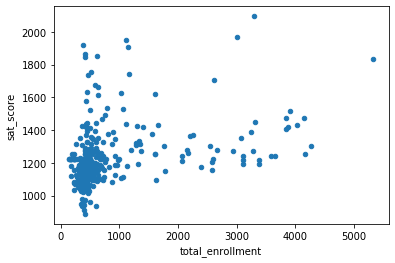

In [43]:
# We will make a scatterplot of total_enrollment vs sat_score. Each point will represent a school, so we'll be able to see if there are any interesting patterns.
combined_cleaned.plot(kind="scatter", x= "total_enrollment", y= "sat_score")
plt.xlabel("total_enrollment")
plt.ylabel("sat_score")
plt.show()

__We can now see that there's no extremely strong correlation between sat_score and total_enrollment.__
__But there might be still something interesting and that is the cluster of points at the bottom left where total_enrollment and sat_score are both low. This might be the reason why r value is high.__

In [44]:
# We will try to filter these schools and show which other r values are high there
low_enrollment = combined_cleaned[combined_cleaned["total_enrollment"] < 1000]
low_enrollment = combined_cleaned[combined_cleaned["sat_score"] < 1000]

In [45]:
low_enrollment = low_enrollment.corr()
low_enrollment = low_enrollment[["sat_score"]]
top_low_enrollment = low_enrollment[low_enrollment["sat_score"] > 0.4]

top_low_enrollment

,sat_score
sat_score,1.000000
Number of Exams with scores 3 4 or 5,0.492923
Total Cohort,0.416241
frl_percent,0.431391
female_per,0.407189
eng_p_11,0.490076
eng_t_11,0.547424
aca_t_11,0.560397
com_tot_11,0.535878
eng_tot_11,0.627989


__There can be many factors which can raise the r value, from Engagement score (eng) to Academic Expectations (aca) and Communication total (com). (tot = total, t = teachers, p = parents)__

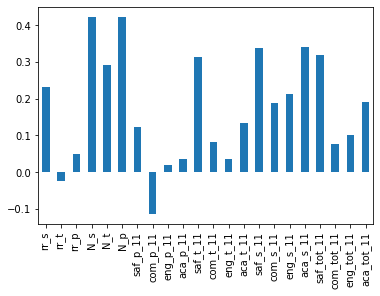

In [46]:
# Plotting correlations just based on those two surveys txt files
# Remove DBN since it's a unique identifier and we don't need it anymore
survey_fields.remove("DBN")

correlations[survey_fields].plot.bar()

#### Safety vs SAT score

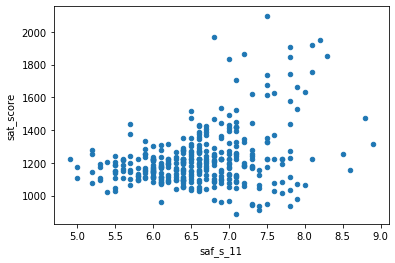

In [47]:
# Let's try to correlate safety (accordint to students = saf_s, their score is higher than teachers = saf_t)
combined_cleaned.plot(kind="scatter", x = "saf_s_11", y = "sat_score")

There appears to be a correlation between SAT scores and safety. There are a few schools with extremely high SAT scores and high safety scores, but as well a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [48]:
scipy.stats.pearsonr(combined_cleaned[["saf_s_11"]], combined_cleaned[["sat_score"]])

(array([0.33763874]), array([3.95711035e-11]))

__The correlation is quite good at 0.33 and we can be sure about this positive correlation thanks to very low p-value of 0.00000000003957, which means that we are 99.99999999996043% certain about this.__

In [49]:
# We will try to visualize the areas of New York and implement the safety scores
# Getting latitude and longitude for NY using Nominatim
address = 'New York City'

geolocator = Nominatim(user_agent="NY_schools")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of NY city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NY city are <function latitude at 0x7f3286f62f28>, <function longitude at 0x7f3287059510>.


In [50]:
# For our map we have to create extra column with school districts. We can get them from DBN as those first two characters.
def get_first_two_chars(dbn):
    return dbn[0:2]

combined_cleaned["school_dist"] = combined_cleaned["DBN"].apply(get_first_two_chars)

In [51]:
# We will make averages of safety for each district
districts_safety = combined_cleaned.groupby(["school_dist", 'boro']).agg(np.mean)
districts_safety.reset_index(inplace=True)
dis_saf_amount = list(range(1,(len(districts_safety) + 1)))


In [52]:

ny = folium.Map(location = [latitude_ny, longitude_ny], zoom_start = 9) # This will set up our basic NY map
x = np.arange(len(districts_safety))
ys = [i + x + (i*x)**2 for i in range(len(districts_safety))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) # setting color scheme
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = [] # adding markers 
for lat, lon, bor, cluster, schd, per in zip(districts_safety['lat'], districts_safety['lon'], districts_safety['boro'],
                                            dis_saf_amount, districts_safety["school_dist"], districts_safety["saf_s_11"]):
    label = folium.Popup(str(bor) + ", school district n. " + schd + ", safety average (0 - 10): " + str(round(per,2)), parse_html=True)
    folium.CircleMarker(           #This all will insert coloured points in the map, which will display infomations about the schools
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ny)
       
ny

It looks like Manhattan and parts of Queens and the Bronx have higher safety scores than Brooklyn, which has it low.

#### Ethnicities vs SAT scores

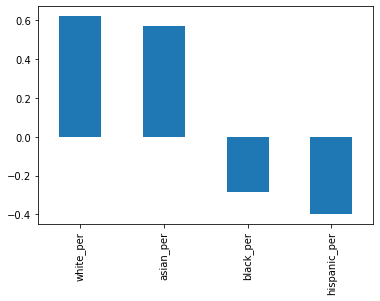

In [53]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[race_fields].plot.bar()

__We can see that there is a high positive correlation at schools with higher percentage of asian or white students and on the other side where there is a higher percentage of black or hispanic students the correlations with sat scores are negative. There can be many reasons, it may be due to a lack of funding for schools in certain areas, lack of teachers/ professionals etc.__

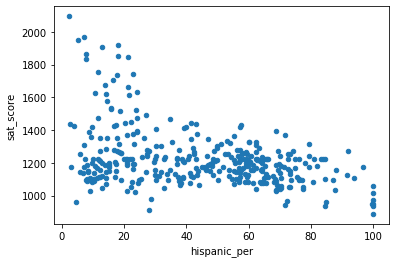

In [54]:
combined_cleaned.plot(kind="scatter", x = "hispanic_per", y = "sat_score")


In [55]:
scipy.stats.pearsonr(combined_cleaned[["hispanic_per"]], combined_cleaned[["sat_score"]])

(array([-0.39698493]), array([3.75210269e-15]))

__The negative correlation with the hispanic group is quite large (-0.397) and we are sure of it on 99.9999999999999962 % (thanks to ver very small p/value of 0.0000000000000038).__ 

In [56]:
combined_cleaned[combined_cleaned["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

__Quick google search showed us that these schools appear to primarily focuse on immigrants. So they have a lot of students who are learning English, which might explain the lower SAT scores.__


In [57]:
# Let's have a look on the other side of the percentage
hisp_low = combined_cleaned[(combined_cleaned["hispanic_per"] < 10)]
hisp_low = hisp_low[(hisp_low["sat_score"] > 1800)]["SCHOOL NAME"]
hisp_low

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

__Well these schools are specialized on science and technology, they receive extra funding, and only admit students who pass an entrance exam. Which doesn't explain the low hispanic_per, but it does explain the high SAT scores.__

#### Gender vs SAT scores

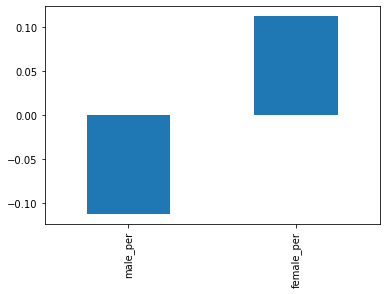

In [58]:
gender = ["male_per", "female_per"]
combined_cleaned.corr()["sat_score"][gender].plot.bar()

__We can see that both correlations are a little bit weak. But as well we can see that females do better on sat scores than males.__

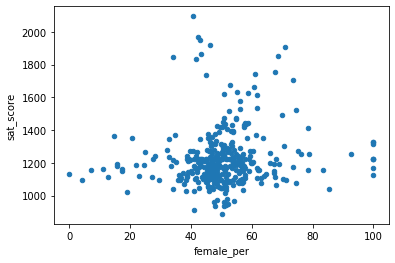

In [59]:
combined_cleaned.plot(kind="scatter", x = "female_per", y = "sat_score")

In [60]:
scipy.stats.pearsonr(combined_cleaned[["female_per"]], combined_cleaned[["sat_score"]])


(array([0.11210774]), array([0.03273586]))

__There is very low correlation between sat_score and female_per (0.112) and we are quite sure with it thank to p-value of 0.0327(96.73% sure),but we can notice a cluster of schools with a high percentage of females (40 to 80) which have a high SAT scores.__

In [61]:
female_high = combined_cleaned[(combined_cleaned["female_per"] > 40)]
female_high = female_high[(female_high["sat_score"] > 1500)]["SCHOOL NAME"]
female_high

4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
5                         BARD HIGH SCHOOL EARLY COLLEGE
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
23                     BARUCH COLLEGE CAMPUS HIGH SCHOOL
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
304                      BENJAM

In [62]:
female_high_2 = combined_cleaned[(combined_cleaned["female_per"] > 60)]
female_high_2 = female_high_2[(female_high_2["sat_score"] > 1700)]["SCHOOL NAME"]
female_high_2

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

__These schools are very selective, have high academic standards and at least the last four are art schools.__

#### AP vs SAT

__In the U.S., high school students take Advanced Placement (AP = https://en.wikipedia.org/wiki/Advanced_Placement_exams) exams to earn college credit. There are AP exams for many different subjects.__

__We will have a look if those students who took AP exams correlate higher with SAT scores, than those who did not. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.__

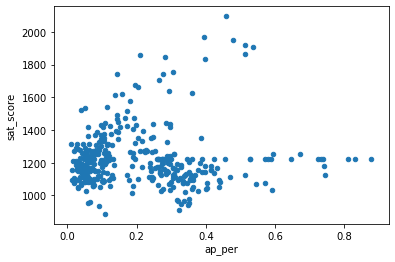

In [63]:
combined_cleaned["ap_per"] = combined_cleaned["AP Test Takers "] / combined_cleaned["total_enrollment"]
combined_cleaned.plot(kind="scatter", x = "ap_per", y = "sat_score")

In [64]:
c, p = scipy.stats.pearsonr(combined_cleaned[["ap_per"]], combined_cleaned[["sat_score"]])
print(c, p)

[0.05717081] [0.27730991]


__The correlation is weak 0.05 which means that there is no real relation between those two, which is backed up by the p-value of 0.277 (we are from 2.77% sure that there is) .__

#### Class size vs SAT scores

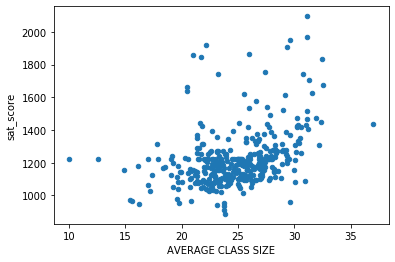

In [65]:
combined_cleaned.plot(kind="scatter", x = "AVERAGE CLASS SIZE", y = "sat_score")

In [66]:
scipy.stats.pearsonr(combined_cleaned[["AVERAGE CLASS SIZE"]], combined_cleaned[["sat_score"]])

(array([0.38101433]), array([5.48634157e-14]))

__We can see that there is a positive correlation and it's with certainty of 99.999999999999946%. And the best results are between the size 20 and 32.__ 

In [67]:
class_high = combined_cleaned[(combined_cleaned["AVERAGE CLASS SIZE"] > 20)]
class_high = class_high[(class_high["sat_score"] > 1600)]["SCHOOL NAME"]
class_high

4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
5                         BARD HIGH SCHOOL EARLY COLLEGE
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
346            BACCALAUREATE SC

__We can see that sizes of the classes with high SAT score are mostly Art and Science schools, which have high academic standards.__

#### Which neighborhoods have the best schools

In [68]:
# Downloading json file with geolocaions of boroughs' borders /polygons' locations
!wget --quiet https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson -O ny_boro.json

In [71]:
# You can simplify the original json file with https://mapshaper.org/ so it will load faster (save it under the same name)
h = os.path.join('ny_boro.json')
ny_boro = json.load(open(h))

In [72]:
sat_aver = combined_cleaned.groupby(['boro']).agg(np.mean)
sat_aver.reset_index(inplace=True)
ny_sat = folium.Map(location = [latitude_ny, longitude_ny], zoom_start = 9) # Creating basic map of NY

# Now plotting on it all four districts
folium.Choropleth(geo_data = ny_boro, data = sat_aver, columns = ['boro', 'sat_score'], key_on = 'feature.properties.BoroName', fill_color = 'YlOrRd', fill_opacity = 0.7, line_opacity=0.2, legend_name = 'SAT score').add_to(ny_sat)
folium.GeoJson(   # Plotting boroughs' names
    ny_boro,
    tooltip=folium.GeoJsonTooltip(fields=['BoroName'],
                                    labels=False,
                                    sticky=False)
).add_to(ny_sat)
ny_sat

__We can see that the best borough based on the highest average SAT score is Staten Island.__

__So these were a few basic comparisons based on our cleaned datasets.__